# 1. Dados do aluno

Jackes Tiago Ferreira da Fonseca - 190030291

# 2. Objetivo

Criar um modelo de NLP (Natural Language Processing) utilizando a biblioteca Transformers do HuggingFace, e participar de uma competição na plataforma Kaggle

# 3. Motivação

A área de Processamento de Linguagem Natural evoluiu drásticamente nos últimos anos permitindo que fossem criados modelos capazes de criar textos automaticamente, traduzir palavras de uma língua para outra e muito mais. Uma área amplamente utilizada em NLP é a de classificação. Por meio dela é possível criar modelos capazes de analisar comentários de redes sociais, comunidades em páginas na web a fim de controlar e identificar aqueles que não estão de acordo com as políticas da organização ou então até mesmo monitorar determinadas categorias de comentários. 

## 3.1 O Desafio 
Para colocar em práticas os conhecimentos referentes a lição 4 do fast.ai, estarei participando da competição [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started) que consiste em criar um modelo capaz de identificar se um tweet diz respeito a um desastre ou não conforme imagem abaixo

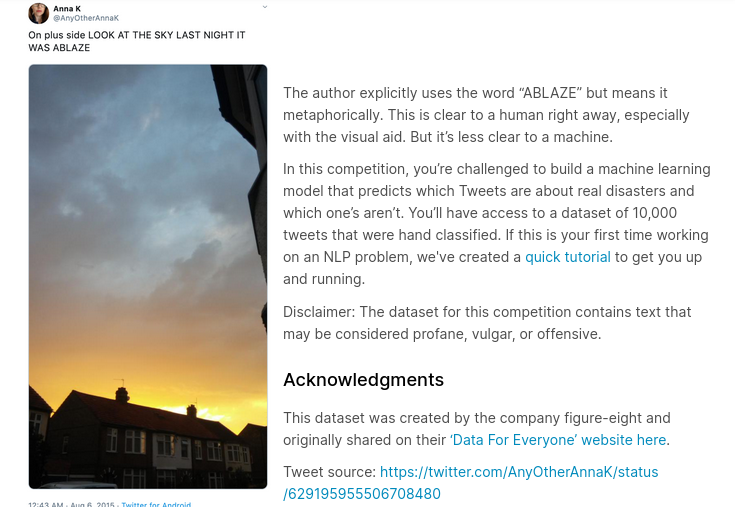

# 4. Modelagem

## 4.1 Instalando e atualizando dependências

Atualização do pip

In [ ]:
!pip install --upgrade pip

API do HuggingFace para subir aplicações

In [2]:
!pip install huggingface_hub

Biblioteca para avaliar e comparar modelos e relatar seu desempenho

In [3]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 292.4 kB/s eta 0:00:0000:0100:01


Houve muitos problemas de versionamento com a biblioteca transformers, porém estes foram solucionados rodando o comando abaixo

In [4]:
!pip install --no-cache-dir transformers sentencepiece

Antes de começar devemos setar o ambiente Kaggle para padronizar localização de arquivos de entrada/saída e dados

In [6]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

Devemos também configurar a API do Kaggle para realizar a interação com competições, onde devemos criar um arquivo chamado `kaggle.json` informando usuário e chave de acesso. Alguns problemas de permissão também ocorreram para acessar o arquivo, onde foi resolvido rodando o comando na última linha desse bloco de código. Temos que por meio do comando`chmod 600` damos permissão de leitura e escrita sobre o arquivo 

In [7]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"jackesdafonseca","key":"abba8b28c5f2648d5d60f68049392137"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

## 4.2 Obtendo dataset 

Após toda a configuração incial, podemos agora fazer o download dos nossos dados que serão utilizados no treinamento. Para isso o Kaggle fornece um comando para baixa-los e armazena-los dentro do seu notebook

In [8]:
!kaggle competitions download -c nlp-getting-started

100%|████████████████████████████████████████| 593k/593k [00:00<00:00, 1.03MB/s]
100%|████████████████████████████████████████| 593k/593k [00:00<00:00, 1.03MB/s]


realizando imports necessários

In [9]:
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from huggingface_hub import notebook_login
from transformers import AutoModelForSequenceClassification,AutoTokenizer
from transformers import TrainingArguments,Trainer
from datasets import Dataset,DatasetDict
import numpy as np 
import pandas as pd 
import kaggle, zipfile
import evaluate
import warnings

# warnings.filterwarnings("ignore", category=UserWarning)

Primeiramente indicamos o caminho onde nossos arquivos precisam ser extraídos 

In [10]:
path = 'nlp-getting-started'

Baixamos e extraímos o dataset

In [11]:
kaggle.api.competition_download_cli(str(path))
zipfile.ZipFile(f'{path}.zip').extractall(path)

nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


Podemos verificar por meio do comando abaixo o conteúdo do nosso diretório. Temos três arquivos: 

- Conjunto de test
- Conjunto de treino
- Arquivo de submissão

In [12]:
!ls {path}

sample_submission.csv  test.csv  train.csv


Podemos então, verificar o conteúdo do arquivo de treino. é possível observar que temos 5 colunas:
- id (identificador)
- keyword (palavra-chave)
- location (localização de quem publicou o tweet)
- text (conteúdo a ser aanalisado)
- target (marcador onde 1 indica que é um tweet sobre um desastre e 0 caso contrário)

Para arquivos CSV - arquivos de texto onde os valores de cada campo são separados por vírgula, podemos utilizar a biblioteca pandas para fazer a leitura e gerar o dataframe.

In [13]:
df = pd.read_csv(path + '/train.csv')
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


Podemos, também, por meio do método `describe` obter uma visão geral das informações que temos no nosso arquivo, como o total de linhas, quantas são únicas, mais recorrentes.

In [14]:
df.describe(include='object')

,keyword,location,text
count,7552,5080,7613
unique,221,3341,7503
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...
freq,45,104,10


Como existem linhas onde as colunas `keyword` e `location` não possuem dados, estas serão removidas a fim de limpar o dataframe

In [15]:
df.drop(columns = ['keyword', 'location'], inplace = True)
df['target'] = df['target'].astype(float)

## 4.3 Treinando o modelo

Sabemos que Redes Neurais trabalham com números. Então, a ideia básica é pegarmos esses números multiplicarmos por matrizes e substituir os negativos por zero, repetimos isso algumas vezes. Então como fazemos isso para strings? Para isso, há basicamente dois passos:
- Tokenização (separa o texto em tokens)
- Numericalização (Transformar cada token em um id único)

### 4.3.1 Tokenização

Para transformar nosso texto em tokens iremos utilizar a biblioteca transformers do HuggingFace. Primeiramente transformamos nosso dataframe do pandas em um dataset do HuggingFace utilizando a função`from_pandas()`

In [16]:
ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['id', 'text', 'target'],
    num_rows: 7613
})

Após separar o texto em tokens iremos obter uma lista de todas palavras únicas que aparecem, chamamos isso de `vocabulário`. E cada uma dessas palavras únicas recebrá um número. Quanto maior o vocabulário, mais dados precisaremos treinar e logo mais memória iremos utilizar. Portanto, em geral não queremos que um vocabulário seja muito grande

Nessa etapa precisamos definir qual modelo iremos utilizar. Em geral, assim como no timm, HuggingFace Transformers possuem diversos modelos pré-treinados de variadas arquiteturas que podem ser acessados [aqui](https://huggingface.co/models). Para esse caso, iremos utilizar o modelo `deberta-v3` que é a que melhor se encaixa para o nosso contexto.

In [17]:
model_nm = 'microsoft/deberta-v3-small'

Para dizer ao Transformers que queremos tokenizar da mesma forma que o modelos que estamos utilizando, chamamos a função `AutoTokenizer`. Quando especificamos `from_pretrained()` ele fará o download do vocabulário e dos detalhes sobre como esse modelo tokenizou o conjunto de dados

In [18]:
tokz = AutoTokenizer.from_pretrained(model_nm)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/578 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.7/site-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Agora, podemos pegar o tokenizador e passar uma string para ele 

In [19]:
tokz.tokenize("Damage to school bus on 80 in multi car crash #BREAKING")

['▁Damage',
 '▁to',
 '▁school',
 '▁bus',
 '▁on',
 '▁80',
 '▁in',
 '▁multi',
 '▁car',
 '▁crash',
 '▁#',
 'BREAK',
 'ING']

Os `_` indicam o começo de uma nova palavra. Então isso é o que acontece quando tokenizamos uma palavra que os desenvolvedores de deberta-v3 usaram.

### 4.3.2 Numericalização

Implementamos a função `tok_func()` que pega a entrada e tansforma em token. Podemos tokenizar várias entradas de uma só vez, utilizando o método `map` onde o argumento `batched=True` executa várias entradas ao mesmo tempo

In [20]:
def tok_func(x): return tokz(x["text"])
tok_ds = ds.map(tok_func, batched=True)

  0%|          | 0/8 [00:00<?, ?ba/s]

Para tokenizar todas as entradas levou apenas alguns segundos

Quando olhamos para primeira linha do nosso conjunto de dados tokenizados, ele terá a primeira entrada e vários números. Esses números é a posição onde aquele token está no vocabulário da string

In [21]:
row = tok_ds[0]
row['text'], row['input_ids']

('Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 [1,
  581,
  65453,
  281,
  262,
  18037,
  265,
  291,
  953,
  117831,
  903,
  4924,
  17018,
  43632,
  381,
  305,
  2])

Então, transformamos uma string em um conjunto de números com sucesso

Podemos verificar a posição de um token dentro do vocabulário por meio do método `vocab`

In [25]:
tokz.vocab['▁on']

277

Para a Transformers, assume que os valores que queremos prever estão na coluna nomeada `labels`. Para isso renomeamos a nossa coluna `target`

In [26]:
tok_ds = tok_ds.rename_columns({'target':'labels'})

ValueError: Original column names {'target'} not in the dataset. Current columns in the dataset: ['id', 'text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask']

## 4.4 Teste e validação

Aqui podemos afirmar que a ideia mais importante dentro do aprendizado de máquina é ter conjunto de treinamento, teste e validação separados. Conjunto de teste e validação tratam de identificar e controlar algo chamado de overfitting. Aqui devemos explicar o conceito de `overfitting` e `underfitting` que são as duas maiores causas de má generalização dos algorítimos de aprendizado de máquina.
- Overfitting: Ocorre quando um modelo estatístico se ajusta muito bem ao conjunto de dados anteriormente observado, mas se mostra ineficaz para prever novos resultados.
- Underfitting: desempenho do modelo já é ruim no próprio treinamento. O modelo não consegue encontrar relações entre as variáveis e o teste nem precisa acontecer.
Portanto, o overfitting é mais difícil de ser identificado.

Para mais informações clique [aqui](https://www.3dimensoes.com.br/post/overfitting-e-underfitting)

 Outros conceitos também são importantes nesse ponto, que dizem respeito ao conjunto de dados:
- Conjunto de treinamento: Conjunto usado para treinar o modelo
- Conjunto de validação: Conjunto que é extraído os dados com o qual não se treina para medir sua precisão (acurácia)
- Conjunto de teste: Usado para comprovar que aquele modelo realmente funciona mas não relata métricas

Veja mais [aqui](https://medium.com/@abnersuniga7/conjuntos-de-treino-teste-e-valida%C3%A7%C3%A3o-em-machine-learning-fast-ai-5da612dcb0ed)

### 4.4.1 Validação

Então, para evitar o overfitting devemos separar um conjunto de validação. Para isso iremos utilizar o étodo `train_test_split()` onde definimos 25% dos dados para a validação.

In [27]:
dds = tok_ds.train_test_split(0.25, seed=42) # 25% para validação e 75% para treino
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5709
    })
    test: Dataset({
        features: ['id', 'text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1904
    })
})

### 4.4.2 Teste

Iremos agora criar o conjunto de teste que vamos chamar de eval, para evitar confusão com o conjunto de dados de teste criado acima.

In [28]:
eval_df = pd.read_csv(path + '/test.csv')
eval_df.drop(columns = ['keyword', 'location'], inplace = True)
eval_df['target'] = df['target'].astype(float)
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

## 4.5 Treinamento

Aqui criamos três variáveis:
- batch size: quantas linhas por vez enviamos para o modelo (para se adequar a nossa CPU)
- epochs: quantas vezes o modelo será ajustado
- lr: taxa de aprendizado (fast.ai fornece um localizador de taxa de aprendizado, mas o Transformers não, então terá que ser tentativa e erro) - indica a que ritimo os pesos são atualizados

In [30]:
bs = 52
epochs = 4
lr = 8e-5

A seguir criamos argumentos de treinamento passando as variáveis que definimos e mais algumas configurações de otimização

In [31]:
args = TrainingArguments(
    'outputs', 
    learning_rate=lr, 
    warmup_ratio=0.1, 
    lr_scheduler_type='cosine',
    evaluation_strategy="epoch", 
    per_device_train_batch_size=bs, 
    per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, 
    weight_decay=0.01, 
    report_to='none')

Agora vamos criar uma métrica para avaliar nossos resultados. Na página da competição é estipulado que a métrica de avaliação será usando a pontuação [F1](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) que pode ser interpretada como uma média harmônica de precisão e recall, onde uma pontuação F1 atinge seu melhor valor em 1 e pior pontuação em 0.

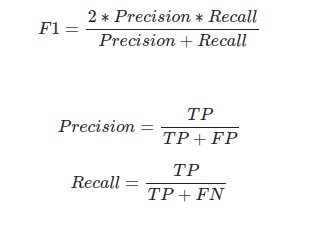

True Positive [TP] = sua previsão é 1, e a correta é 1 - você preveu positivo, portanto é verdadeiro.
False Positive [FP] = sua previsão é 1, e a correta é 0 - você preveu positivo, portanto é falso.
False Negative [FN] = sua previsão é 0, e a correta é 1 - você preveu negativo, portanto é falso.

OBS.: As métricas de validação são utilizadas para analisar a qualidade dos modelos de Machine Learning

Para a criação das métricas iremos utilizar o método `evaluate` do HuggingFace. Uma função para computar métricas que seja útil ela deve pegar um objeto de predição e retornar um dicionário mapeando strings para floats, conforme descrito [aqui](https://huggingface.co/course/chapter3/3?fw=pt).

In [32]:
def compute_metrics(eval_preds):
    metric = evaluate.load('f1')
    logits, labels = eval_preds
    predictions = np.clip(logits, 0, 1)
    return metric.compute(predictions=predictions, references=labels)

Por fim, criamos o modelo e o `trainer` que faz o mesmo papel que o `learner` do fast.ai 

In [33]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(
    model, 
    args, 
    train_dataset=dds['train'], 
    eval_dataset=dds['test'],
    tokenizer=tokz, 
    compute_metrics=compute_metrics
    )

Downloading:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

Treinando o modelo

In [34]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: id, text. If id, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5709
  Num Epochs = 4
  Instantaneous batch size per device = 52
  Total train batch size (w. parallel, distributed & accumulation) = 52
  Gradient Accumulation steps = 1
  Total optimization steps = 440


Epoch,Training Loss,Validation Loss,F1
1,No log,0.134533,0.692729
2,No log,0.133424,0.678206
3,No log,0.131887,0.617940
4,No log,0.154959,0.750359


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: id, text. If id, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1904
  Batch size = 104


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: id, text. If id, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1904
  Batch size = 104
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: id, text. If id, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1904
  Batch size = 104
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: id, text. If id, text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation ***

TrainOutput(global_step=440, training_loss=0.10779369527643377, metrics={'train_runtime': 4849.1298, 'train_samples_per_second': 4.709, 'train_steps_per_second': 0.091, 'total_flos': 358432885296450.0, 'train_loss': 0.10779369527643377, 'epoch': 4.0})

Levou bastante tempo para executar. Cerca de 1h20min

Verificamos algumas previsões

In [35]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds

The following columns in the test set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: id, text, target. If id, text, target are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3263
  Batch size = 104


array([[1.08854771],
       [1.08492517],
       [1.07989788],
       ...,
       [1.08633721],
       [1.07942617],
       [1.0651536 ]])

Como queremos valores entre 0 e 1, utilizamos o método `clip` para fazer esse ajuste

In [36]:
preds = np.clip(preds, 0, 1)
preds

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

## 4.6 Submissão do modelo

Para submetermos nosso resultado no Kaggle, devemos enviar um arquivo igual ao exemplo que foi passado, no padrão .CSV

Primeiramente fazemos o cast de preds para `int`

In [38]:
preds = [int(x) for x in preds]

Depois geramos o arquivo .CSV

In [39]:
submission = Dataset.from_dict({
    'id': eval_ds['id'],
    'target': preds
})

submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

22746

In [40]:
sub = pd.read_csv('submission.csv')
sub

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


# 5. Resultado da competição

Após a submissão do arquivo na página da competição, pude verificar que fiquei na posição 213

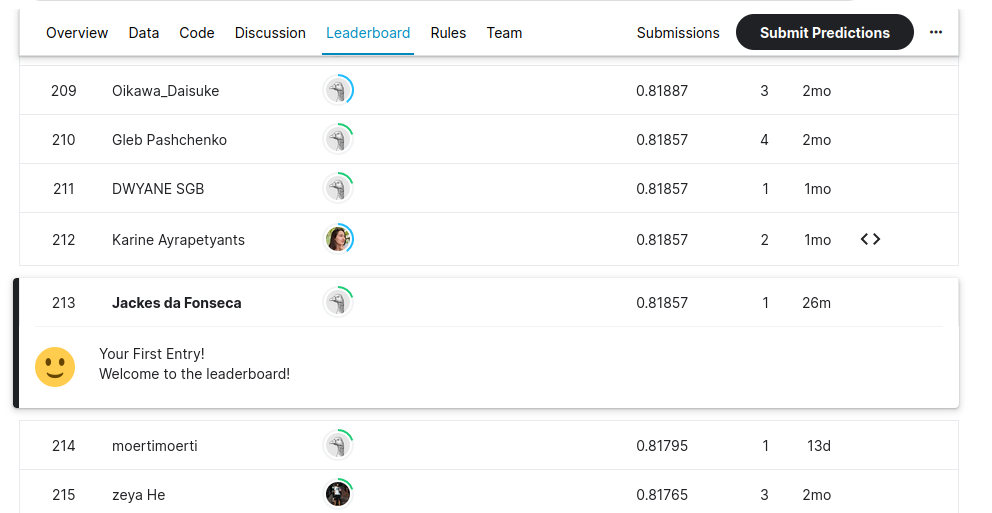

# 6. Fazendo o deploy da aplicação

Utilizaremos a biblioteca `HuggingFace_Hub`

Fazemos login no HuggingFace

In [49]:
notebook_login()

Utilizamos a biblioteca `curl` de transferência de url

In [66]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Detected operating system as Ubuntu/focal.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Detected apt version as 2.0.9
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... Packagecloud gpg key imported to /etc/apt/keyrings/github_git-lfs-archive-keyring.gpg
done.
Running apt-get update... done.

The repository is setup! You can now install packages.


Instalamos a extensão `git-lfs` para arquivos que demandam grande espaço de armazenamento 

In [67]:
!sudo apt-get install git-lfs

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 101 not upgraded.
Need to get 7419 kB of archives.
After this operation, 16.0 MB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu focal/main amd64 git-lfs amd64 3.3.0 [7419 kB]
Fetched 7419 kB in 3s (2302 kB/s)                             
Selecting previously unselected package git-lfs.
(Reading database ... 106350 files and directories currently installed.)
Preparing to unpack .../git-lfs_3.3.0_amd64.deb ...
Unpacking git-lfs (3.

Subimos para o HuggingFace

In [68]:
trainer.push_to_hub("competition")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/opt/conda/lib/python3.7/site-packages/huggingface_hub/repository.py:708: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.11.
  FutureWarning,
Cloning https://huggingface.co/jackesfonseca/outputs into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Saving model checkpoint to outputs
Configuration saved in outputs/config.json
Model weights saved in outputs/pytorch_model.bin
tokenizer config file saved in outputs/tokenizer_config.json
Special tokens file saved in outputs/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 32.0k/541M [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.17k/3.17k [00:00<?, ?B/s]

Upload file spm.model:   1%|1         | 32.0k/2.35M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/jackesfonseca/outputs
   65bc8f8..4b06f61  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'F1', 'type': 'f1', 'value': 0.7503586800573888}]}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/jackesfonseca/outputs
   4b06f61..20239a5  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/jackesfonseca/outputs/commit/4b06f6129f2fe7b8ea0fe91eb68fd8ea705fe0f9'

[Link](https://huggingface.co/spaces/jackesfonseca/jackesfonseca-outputs) para o HuggingFace Space

[Link](https://huggingface.co/jackesfonseca/outputs) para o card do modelo